# Make sure that experiment predictions are the same
need a tolerance of 0.05 to compare latents. Need the same for models with old code, when predicting twice. This seems to be an instability in keras. Could not get results to reproduce exactly, even when setting all random seeds as described here  https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [24]:
import numpy as np
from miann.data import MPPData
import os
import tqdm
from miann.constants import EXPERIMENT_DIR
import scanpy as sc
import matplotlib.pyplot as plt

In [40]:
results_old = '/home/icb/hannah.spitzer/projects/pelkmans/local_experiments/2021-04-27_VAE_all/CondVAE_pert-CC2'
dataset_old = '/home/icb/hannah.spitzer/projects/pelkmans/local_data/NascentRNA/datasets/184A1_all_frac0005_neigh3_cond_pert-CC'

results_new = 'VAE_all/CondVAE_pert-CC/results_epoch025/val'

mpp_data = MPPData.from_data_dir(data_dir=results_new, base_dir=EXPERIMENT_DIR)
adata = sc.read(os.path.join(results_old, 'adata_epoch025_val.h5ad'))

In [16]:
# check that have same mapobject_ids
(np.unique(adata.obs['mapobject_id']) == np.unique(mpp_data.obj_ids)).all()

True

In [76]:
# check that have same content (but ordering is different due to different implementation of subsampling per object frac)
obj_ids = np.unique(mpp_data.obj_ids)
for obj_id in tqdm.tqdm(obj_ids):
    mask_old = np.array(adata.obs['mapobject_id'] == obj_id)
    mask = mpp_data.obj_ids == obj_id
    # check that have same length
    assert len(mask_old.nonzero()[0]) == len(mask.nonzero()[0])
    # check that values of one channel are the same (ordering is different)
    ch_id = np.random.choice(range(34))
    vals_old = adata.X[mask_old][:,ch_id]
    vals_new = mpp_data.center_mpp[mask][:,ch_id]
    assert set(vals_old) == set(vals_new)
    
    # check that values of latent space are the same
    # are only the same with tolerance of 0.05 - is this due to numerical instability? 
    # I think yes, as I have seen this before, when predicting the same data on the same model
    ch_id = np.random.choice(range(16))
    latent_old = adata.obsm['X_latent'][mask_old][:,ch_id]
    latent_new = mpp_data.data('latent')[mask][:,ch_id]
    assert (np.isclose(sorted(latent_old), sorted(latent_new), atol=0.05)).all()


100%|██████████| 1181/1181 [00:00<00:00, 1197.84it/s]


cannot compare images, because have different obj_ids chosen. This is becaues used np.random.choice in older code, and now use np.random.default_rng().choice

In [49]:
# look at images
img_old = np.load(os.path.join(results_old, 'pred_imgs_epoch025_val.npy'))
# also need old ds to get mapobject ids
ds_old = np.load(os.path.join(dataset_old, f'val_imgs.npz'))
img_new = MPPData.from_data_dir(results_new+'_imgs', base_dir=EXPERIMENT_DIR, optional_keys=['decoder'])

In [66]:
import pandas as pd
obj_ids_old = pd.read_csv(os.path.join(results_old, 'img_ids_val.csv'), header=None)
obj_ids_old = list(obj_ids_old[0].astype(int))

In [69]:
ds_old['mapobject_id'][obj_ids_old]

array([372811, 255443, 368196, 311499, 214922, 279440, 216662, 375096,
       276554, 220668, 350075, 321072, 292313, 376735, 313694, 280498,
       329184, 249355, 208019, 359372, 210691, 251037, 312351, 379761,
       228479])

In [64]:
img_new.unique_obj_ids

array([210685, 210707, 211304, 216972, 228504, 232430, 273005, 286156,
       287441, 291621, 300407, 303066, 304817, 324847, 332646, 336436,
       337404, 343014, 343851, 347293, 347389, 351613, 352396, 371513,
       379368], dtype=uint32)

## Look at evaluation images
- mse is very similar. Good!
TODO compare computationally!

In [78]:
from IPython.display import Image

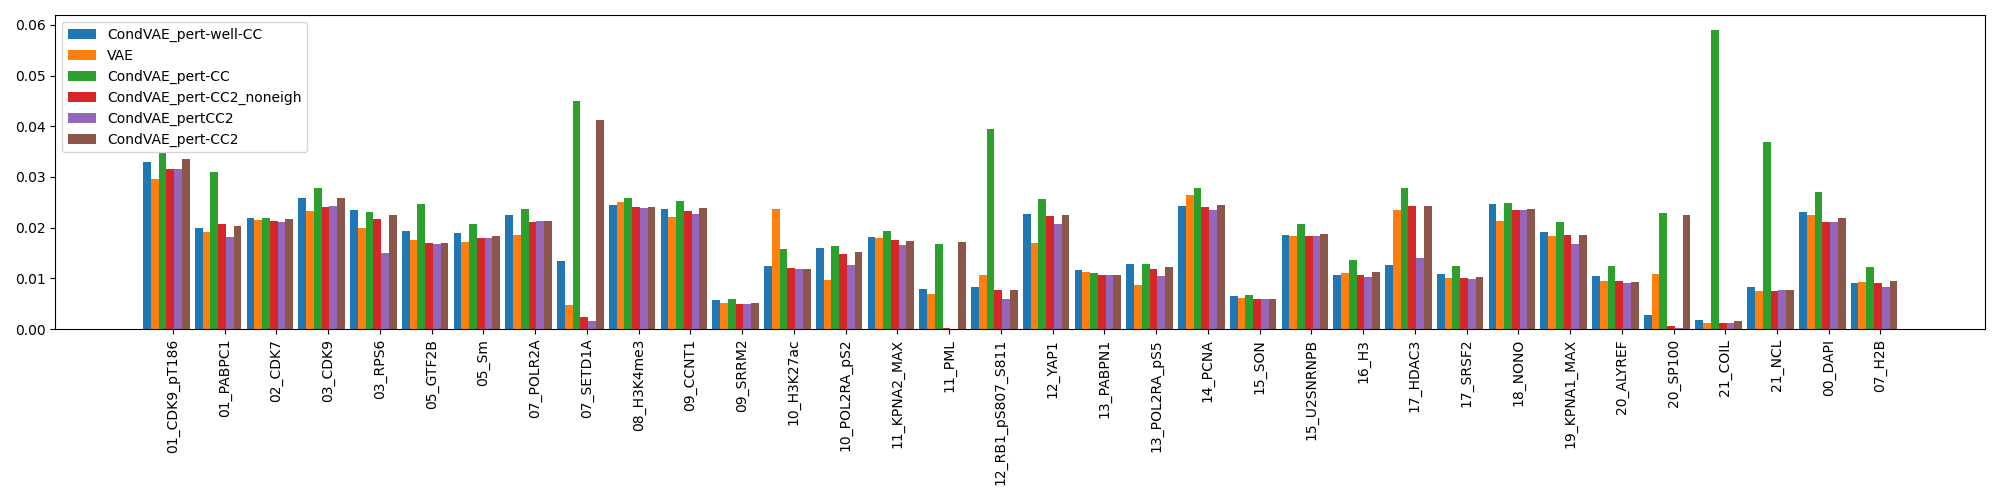

In [79]:
Image(os.path.join(results_old, '../per_channel_mse.png'))

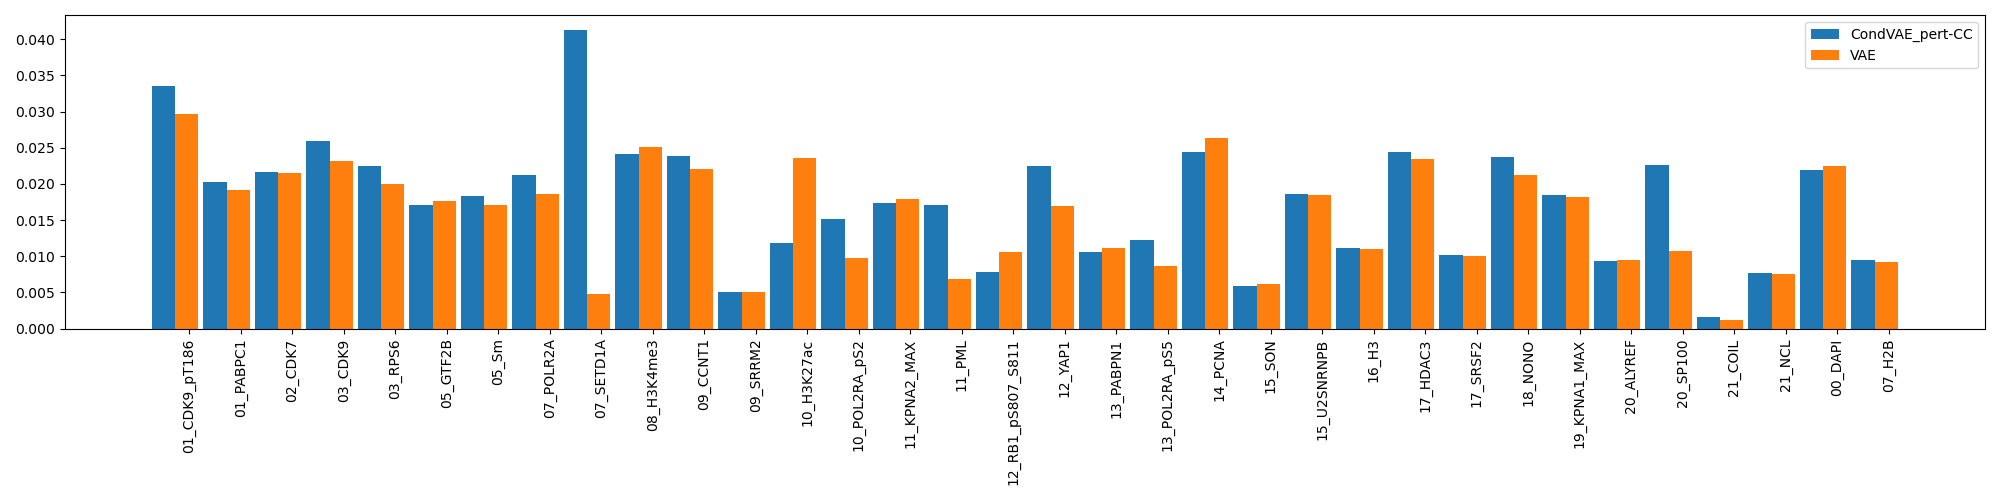

In [81]:
Image(os.path.join(EXPERIMENT_DIR, results_new, '../../../per_channel_mse.png'))

# Check that loading weights works
yes, all weights are initialised

In [12]:
from miann.tl._models import VAEModel 
from miann.tl import Experiment, Predictor
import logging
import tensorflow as tf
logging.basicConfig(level=logging.INFO)

In [13]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC


In [16]:
model = VAEModel(**exp.config['model']['model_kwargs'])

INFO:VAEModel:Creating model


In [18]:
# get uninit weights
uninit_weights = model.model.get_weights()

In [19]:
# initialise
weights_path = tf.train.latest_checkpoint(exp.full_path)
model.model.load_weights(weights_path)
# get init weights
init_weights = model.model.get_weights()

In [29]:
for i in range(len(init_weights)):
    assert (init_weights[i] != uninit_weights[i]).any()

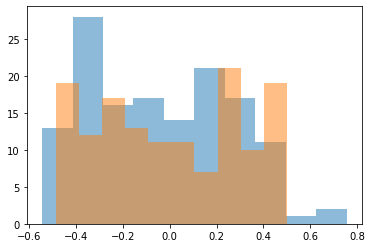

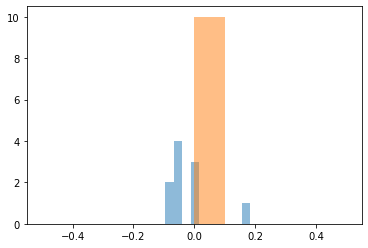

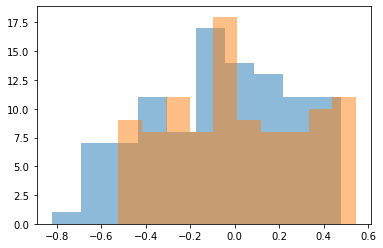

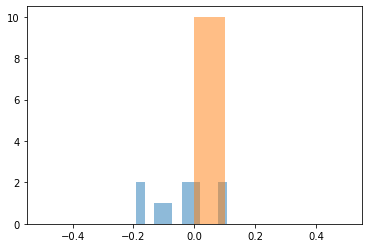

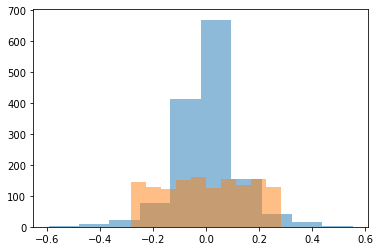

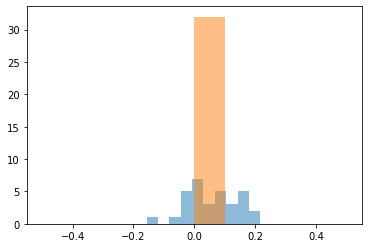

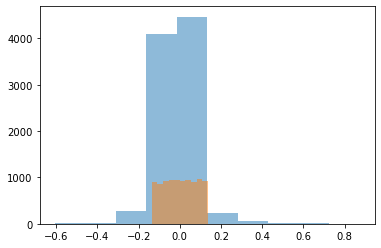

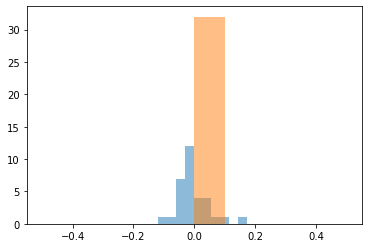

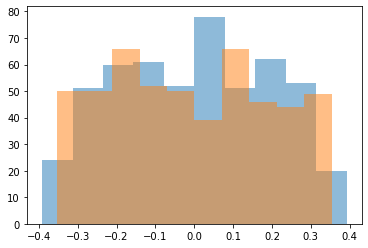

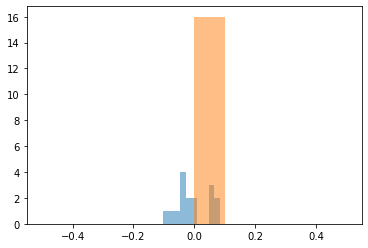

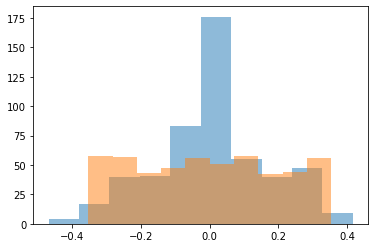

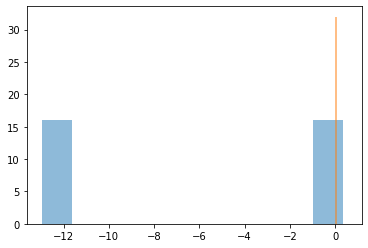

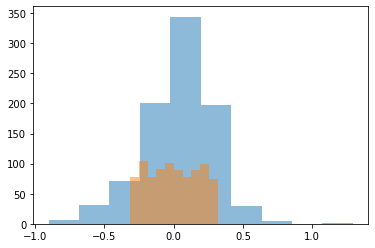

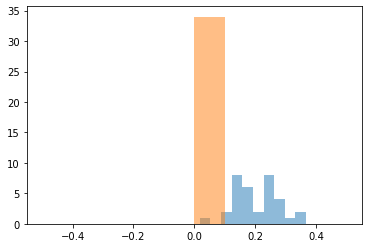

In [28]:
import matplotlib.pyplot as plt

for i in range(len(init_weights)):
    plt.hist(init_weights[i].flatten(), alpha=0.5)
    plt.hist(uninit_weights[i].flatten(), alpha=0.5)
    plt.show()

# Check variation in latent space prediction
Have a very small mean differece per latent space channel (0.2-0.6% of range of values)

In [30]:
from miann.tl import Experiment, Predictor
import logging
import tensorflow as tf
logging.basicConfig(level=logging.INFO)

In [31]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
pred = Predictor(exp)

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Predictor:Creating Predictor for VAE_all/CondVAE_pert-CC
INFO:VAEModel:Creating model
INFO:Estimator:Initializing model with weights from /Users/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/CondVAE_pert-CC/weights_epoch025
INFO:MPPData:Created new: MPPData for NascentRNA (615240 mpps with shape (3, 3, 34) from 9472 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_all_frac0005_neigh3_cond_pert-CC/train.
INFO:MPPData:Created new: MPPData for NascentRNA (76432 mpps with shape (3, 3, 34) from 1181 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Loaded data from /Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/datasets/184A1_al

In [40]:
pred1 = pred.est.model.encoder.predict(pred.est.val_dataset.batch(128))
pred2 = pred.est.model.encoder.predict(pred.est.val_dataset.batch(128))

In [63]:
# mean difference per channel relative to range of values
np.mean(np.abs(pred1 - pred2) / (np.quantile(pred1, 0.99, axis=0) - np.quantile(pred1, 0.01, axis=0)), axis=0)

array([0.00319007, 0.00482701, 0.00470922, 0.00621537, 0.00224269,
       0.0055477 , 0.00507896, 0.00385937, 0.0051574 , 0.0017402 ,
       0.00279519, 0.00364097, 0.00273828, 0.00280283, 0.00273457,
       0.00664099])